In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import yt

from spectral_cube import SpectralCube
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS


from astropy.io import fits

from pvextractor import Path
from pvextractor import extract_pv_slice

%matplotlib notebook

In [67]:
globule = 'GlobB'
source = 'HCOp'

path = globule + '_' + source + '.image.pbcor.fits'
cube = SpectralCube.read(path)
header = cube[0].header

new_cube = fits.open(path)
data = new_cube[0].data
new_header = new_cube[0].header
#print(header)

crp1 = header['CRPIX1']
crp2 = header['CRPIX2']
#crp3 = header['CRPIX3']
crv1 = header['CRVAL1']
crv2 = header['CRVAL2']
#crv3 = header['CRVAL3']
cd1 = header['CDELT1']
cd2 = header['CDELT2']
#cd3 = header['CDELT3']

freq_start = new_header['CRVAL3'] #header['CRVAL3'] #frequency of initial channel in Hz (Channel 0)
freq_res = new_header['CDELT3'] #header['CDELT3'] #spectral resolution, in Hz
rest_freq = new_header['RESTFRQ'] #header['RESTFRQ'] # Systemic freq in header in Hz
c_vel = 3e5 #speed of light in km/s
vel_start = -c_vel*(1 - freq_start/rest_freq) #velocity of initial channel
vel_change = c_vel*freq_res/rest_freq #Change in velocity per channel

# DEFINING USEFUL CONVERSION FUNCTIONS

def hms(hour, mint, sec): # Converts RA hh:mm:ss into degrees
    degree = (hour + (mint + sec/60.)/60.)*360/24
    return degree

def dms(deg, mint, sec): # Converts Dec dd:mm:ss into degrees
    if deg > 0.:
        degree = deg + (mint + sec/60.)/60.
    else:
        degree = -(-deg + (mint + sec/60.)/60.)
    return degree

def Vel_to_Ch(vel_in): # Takes Velocity # and converts to proper channel #
    chan_out = -np.int((vel_in + vel_start) / vel_change)
    return chan_out
def Ch_to_Vel(chan): # Converts Channel number to Velocity
    vel_out = -chan*vel_change - vel_start
    return vel_out

V1 = Vel_to_Ch(-15)
#V1 = 50
#Vsys = Vel_to_Ch(-16.6)
V2 = Vel_to_Ch(-19)
#V2 = 0
print(V1, V2)

def Pix_to_Angle(PixIn, axis): # Converts image pixel values to RA and Dec angles
    if axis == 'dec':
        Angle = (PixIn - crp2) * cd2 + crv2
    if axis == 'ra':
        Angle = (PixIn - crp1) * cd1 + crv1
    return Angle

def Angle_to_Pix(Angle, axis): # Converts RA or Dec value to image pixel value
    if axis == 'dec':
        PixVal = np.int(crp2 + (Angle - crv2)/cd2)
    if axis == 'ra':
        PixVal = np.int(crp1 + (Angle - crv1)/cd1)
    return PixVal

bmaj = (header["BMAJ"])/(-cd1)
bmin = (header["BMIN"])/cd2
#print(crv2)

# DEFINING THE BOUNDS OF THE IMAGE IN RA/DEC AND PIXELS

ra_center = hms(22, 29, 43.26) #Degrees (5h35m23s) 83.84757
dec_center = dms(-20, 48, 56.77) #Degrees (-5:12:00)
#ra_img = 83.8542 #5:35:25
#dec_img = -5.197 #-5:11:50

if globule == 'GlobC':
    rabox_min = 337.40565 #hms(22, 29, 42.72)	#ra_center+1.5/240.
    rabox_max = 337.40975 #hms(22, 29, 43.80)	#ra_center-0.5/240.
    decbox_min = -20.802 #dms(-20, 49, 04.80)	#dec_center+1/240.
    decbox_max = -20.796 #dms(-20, 48, 48.74)	#dec_center+3/240.
elif globule == 'GlobB':
    rabox_min = 337.428
    rabox_max = 337.4325
    decbox_min = -20.818
    decbox_max = -20.81354

xbox_min = Angle_to_Pix(rabox_max, 'ra')
xbox_max = Angle_to_Pix(rabox_min, 'ra')
xbox_center = Angle_to_Pix(ra_center, 'ra')
ybox_min = Angle_to_Pix(decbox_min, 'dec')
ybox_max = Angle_to_Pix(decbox_max, 'dec')
ybox_center = Angle_to_Pix(dec_center, 'dec')

bmaj_deg = dms(0, 0, 1.23610949685072)
print(bmaj_deg)

#bmaj = Angle_to_Pix(1.23610949685072, 'ra')
#bmin = Angle_to_Pix(header['BMIN'], 'dec')

#print(bmaj, bmin)

print('Box Dimensions: ', xbox_min, '-', xbox_max, ',', ybox_min, '-', ybox_max, 'in pixels')
print('Box Dimensions: ', rabox_min, '-', rabox_max, ',', decbox_min, '-', decbox_max, 'in degrees')

cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention = "optical")
print(cube_kms.shape)
cube_small = cube_kms[V2:V1,ybox_min:ybox_max,xbox_min:xbox_max] #Channels, Dec range, RA range
# Channel 956 is 11.3 km/s, or about the central velocity
# Channel 820 is 97.6 km/s, or the end of the redshifted jet (other end is 32.5km/s or Chan 922)
print(cube_small.shape)

31 23
-0.00034336374912520004
Box Dimensions:  234 - 329 , 288 - 383 in pixels
Box Dimensions:  337.428 - 337.4325 , -20.818 - -20.81354 in degrees
(50, 600, 600)
(8, 95, 95)


In [68]:
g = SkyCoord([337.428, 337.4325], [-20.81577, -20.81577], frame = 'icrs', unit = 'deg')
path4 = Path(g, width = 0.00223 * u.deg)

<IPython.core.display.Javascript object>


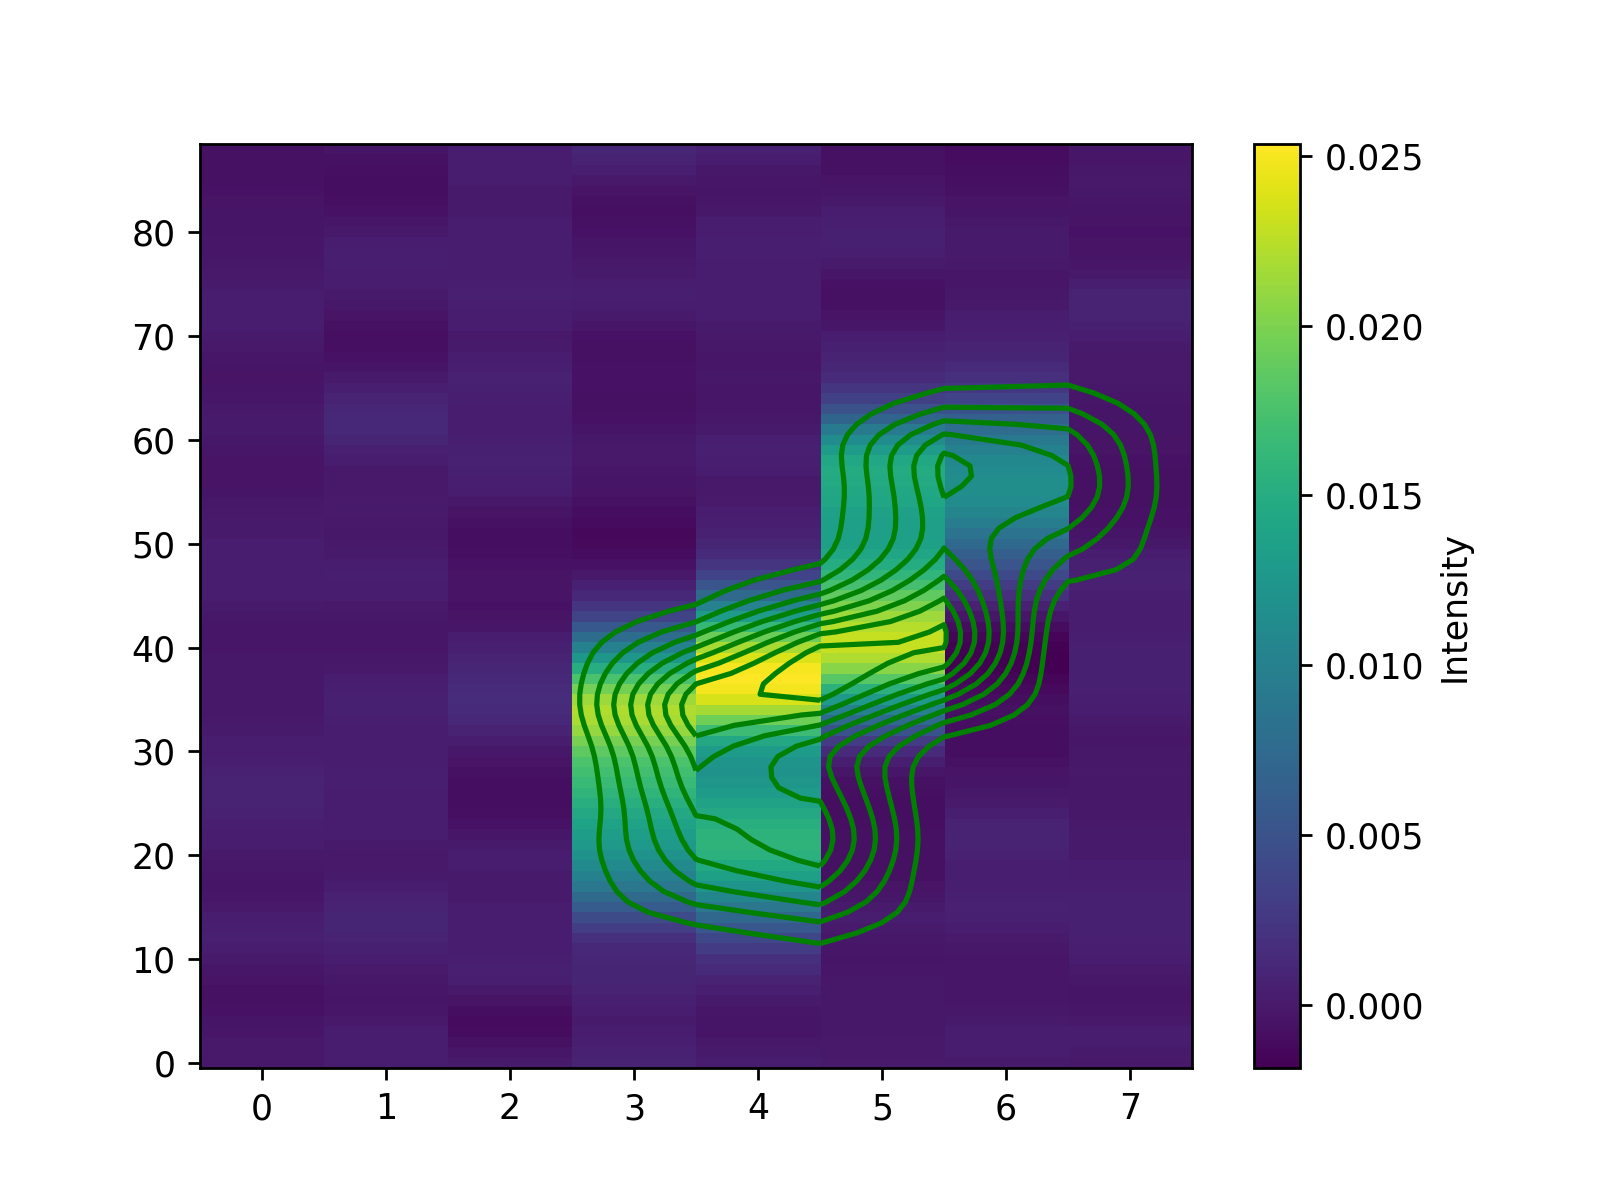

In [71]:
slice1 = extract_pv_slice(cube_small, path4)

fig = plt.figure()
#print(type(new_slice))
#plt.imshow(new_slice.data)
ax = fig.add_subplot(111)
im = ax.imshow(slice1.data.T, aspect = 'auto', origin = 'lower')
levels = np.linspace(0, np.nanmax(slice1.data), 10)
plt.contour(slice1.data.T, levels = levels[1:10], colors = 'green', origin = 'lower')
fig.colorbar(im, label = "Intensity")